# 1. Kết nối tới drive , import một số thư viện cần thiết

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential
from keras.layers import Dense, GRU

In [3]:
VNP = pd.read_csv("/content/drive/MyDrive/DAB Final Project/Source Code/Dataset/VNP.csv")

In [4]:
VNP

,Date,Price,Open,High,Low,Vol.,Change %
0,12/1/2017,5100,5200,5200,4900,42.50K,-1.92%
1,12/4/2017,5800,5100,5800,5100,574.50K,13.73%
2,12/5/2017,5700,6000,6000,5600,218.50K,-1.72%
3,12/6/2017,5800,5800,5800,5700,176.41K,1.75%
4,12/7/2017,6300,5800,6400,5600,307.82K,8.62%
...,...,...,...,...,...,...,...
1225,6/5/2023,14700,15500,15500,14700,18.00K,-0.68%
1226,6/6/2023,14900,14600,14900,14600,1.80K,1.36%
1227,6/7/2023,14800,14800,15500,14600,10.02K,-0.67%
1228,6/8/2023,14400,14900,14900,14300,8.80K,-2.70%


In [5]:
VNP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1230 non-null   object
 1   Price     1230 non-null   int64 
 2   Open      1230 non-null   int64 
 3   High      1230 non-null   int64 
 4   Low       1230 non-null   int64 
 5   Vol.      1229 non-null   object
 6   Change %  1230 non-null   object
dtypes: int64(4), object(3)
memory usage: 67.4+ KB


# 2. Tiền xử lý dữ liệu

### Loại bỏ một số dữ liệu trống trong dataset

In [6]:
# Drop missing values
VNP = VNP.dropna()

In [7]:
VNP1 = VNP.reset_index()['Price']

In [8]:
VNP['Index'] = np.arange(len(VNP.index))

<ipython-input-8-73e229cbfeac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VNP['Index'] = np.arange(len(VNP.index))


<h1> 3.Scale dữ liệu

In [9]:
scaler=MinMaxScaler(feature_range=(0,1))
VNP1=scaler.fit_transform(np.array(VNP1).reshape(-1,1))

# 4. Chia tập dữ liệu để train-test-validate theo tỉ lệ 7:2:1

In [10]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(VNP1))
test_size = int(0.2 * len(VNP1))
val_size = len(VNP1) - train_size - test_size

In [11]:
train_data = VNP1[:train_size]
test_data = VNP1[train_size:train_size+test_size]
val_data = VNP1[train_size+test_size:]

<h1>Hàm Create Dataset

In [12]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [13]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [14]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [15]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
#Model fitting
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 4s 104ms/step - loss: 0.0445 - val_loss: 0.0049
Epoch 2/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0122 - val_loss: 0.0011
Epoch 3/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 4/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0013 - val_loss: 8.9169e-04
Epoch 5/100
12/12 [==============================] - 1s 62ms/step - loss: 6.2723e-04 - val_loss: 7.3178e-04
Epoch 6/100
12/12 [==============================] - 1s 63ms/step - loss: 6.0426e-04 - val_loss: 8.0820e-04
Epoch 7/100
12/12 [==============================] - 1s 61ms/step - loss: 5.3322e-04 - val_loss: 8.7452e-04
Epoch 8/100
12/12 [==============================] - 1s 60ms/step - loss: 5.2645e-04 - val_loss: 7.4722e-04
Epoch 9/100
12/12 [==============================] - 1s 62ms/step - loss: 5.1540e-04 - val_loss: 8.9496e-04
Epoch 10/100
12/12 [==============================] - 1

<h1>Dự báo dữ liệu test, val

In [17]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 28ms/step


<h1>Chuẩn hóa dữ liệu

In [18]:
#Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [19]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[16800.],
       [17500.],
       [17100.],
       [17100.],
       [16800.],
       [16700.],
       [17100.],
       [18400.],
       [18600.],
       [18100.],
       [18300.],
       [18300.],
       [17800.],
       [17400.],
       [18000.],
       [17100.],
       [17700.],
       [17900.],
       [17600.],
       [17200.],
       [16900.],
       [16000.],
       [15400.],
       [16200.],
       [14600.],
       [14500.],
       [13600.],
       [14100.],
       [14800.],
       [15100.],
       [15200.],
       [15400.],
       [14700.],
       [14800.],
       [15000.],
       [15200.],
       [15000.],
       [15100.],
       [15000.],
       [14900.],
       [14600.],
       [14800.],
       [14600.],
       [14800.],
       [15300.],
       [15400.],
       [15200.],
       [15800.],
       [16600.],
       [15900.],
       [15800.],
       [16100.],
       [15700.],
       [15900.],
       [15900.],
       [15900.],
       [15700.],
       [15800.],
       [16100.

In [20]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[13200.],
       [13000.],
       [12600.],
       [12200.],
       [12900.],
       [12500.],
       [12300.],
       [12400.],
       [12600.],
       [12500.],
       [12300.],
       [12800.],
       [12000.],
       [12700.],
       [13400.],
       [14700.],
       [14500.],
       [14200.],
       [14800.],
       [14700.],
       [14900.],
       [14800.],
       [14400.]])

<h1>Đánh giá độ chính xác của thuật toán

In [21]:
# RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 499.85787938563016
Testing RMSE: 573.8825933026236


In [22]:
#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 380.66278872282584
Testing MAE: 417.4841444227431


In [23]:
#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 2.8628163405089966
Testing MAPE: 3.044807761330728


<h1>Quá trình dự đoán giá cổ phiếu trong 30 ngày tiếp theo

In [24]:
x_input=val_data[24:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.40155458]
101
1 day input [0.25555556 0.24814815 0.25185185 0.25925926 0.26296296 0.27037037
 0.24074074 0.24814815 0.25555556 0.24444444 0.24074074 0.23333333
 0.24074074 0.23333333 0.25185185 0.24814815 0.25185185 0.24444444
 0.25925926 0.24444444 0.24814815 0.25185185 0.25185185 0.26666667
 0.27037037 0.27777778 0.26666667 0.27407407 0.28518519 0.27777778
 0.28518519 0.27407407 0.2962963  0.28518519 0.3        0.28888889
 0.3        0.27777778 0.28888889 0.26296296 0.25925926 0.25555556
 0.25925926 0.27777778 0.3        0.27777778 0.25925926 0.26296296
 0.26296296 0.26666667 0.27037037 0.26666667 0.25185185 0.24814815
 0.25925926 0.28148148 0.26666667 0.26296296 0.27777778 0.25925926
 0.25925926 0.25925926 0.25925926 0.24814815 0.31111111 0.36666667
 0.3962963  0.34444444 0.32222222 0.37407407 0.35185185 0.33703704
 0.35925926 0.33703704 0.34444444 0.35185185 0.34444444 0.32962963
 0.31481481 0.34074074 0.32592593 0.31851852 0.32222222 0.32962963
 0.32592593 0.31851852 0.33703704

In [25]:
print(scaler.inverse_transform(lst_output))

[[14541.97378159]
 [14589.2428875 ]
 [14652.00175047]
 [14719.51134205]
 [14788.93844485]
 [14859.31665897]
 [14930.27423024]
 [15001.63091421]
 [15073.27164412]
 [15145.11756301]
 [15217.11314917]
 [15289.21253681]
 [15361.38353944]
 [15433.59557986]
 [15505.82773685]
 [15578.0566752 ]
 [15650.26469231]
 [15722.43730426]
 [15794.55358982]
 [15866.60630703]
 [15938.57614398]
 [16010.44781208]
 [16082.21004605]
 [16153.84836197]
 [16225.3482759 ]
 [16296.69771791]
 [16367.88059473]
 [16438.88725042]
 [16509.70078707]
 [16580.30833006]]


<h1>Vẽ hình mô tả dự đoán

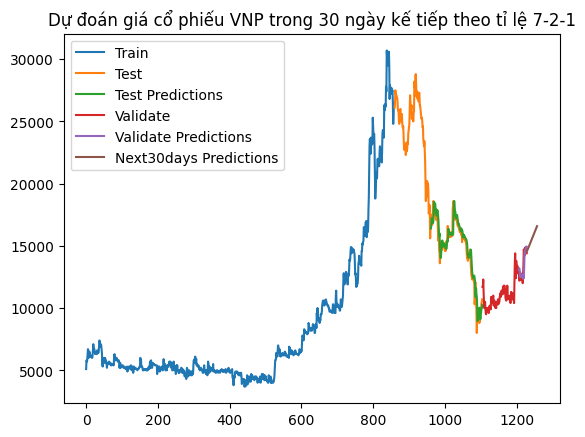

In [26]:
#Drawing plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(VNP1)-1, stop=len(VNP1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Test Predictions','Validate','Validate Predictions','Next30days Predictions'])
plt.title("Dự đoán giá cổ phiếu VNP trong 30 ngày kế tiếp theo tỉ lệ 7-2-1")
plt.show()

# 5. Chia tập dữ liệu để train-test-validate theo tỉ lệ 6:3:1

In [27]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(VNP1))
test_size = int(0.3 * len(VNP1))
val_size = len(VNP1) - train_size - test_size

In [28]:
train_data = VNP1[:train_size]
test_data = VNP1[train_size:train_size+test_size]
val_data = VNP1[train_size+test_size:]

<h1>Hàm Create Dataset

In [29]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [30]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [31]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [32]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
#Model fitting
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
10/10 [==============================] - 5s 141ms/step - loss: 0.0039 - val_loss: 0.0377
Epoch 2/100
10/10 [==============================] - 1s 67ms/step - loss: 0.0013 - val_loss: 0.0236
Epoch 3/100
10/10 [==============================] - 1s 66ms/step - loss: 4.6039e-04 - val_loss: 0.0039
Epoch 4/100
10/10 [==============================] - 1s 66ms/step - loss: 2.0510e-04 - val_loss: 0.0035
Epoch 5/100
10/10 [==============================] - 1s 68ms/step - loss: 1.8348e-04 - val_loss: 0.0031
Epoch 6/100
10/10 [==============================] - 1s 69ms/step - loss: 1.4536e-04 - val_loss: 0.0014
Epoch 7/100
10/10 [==============================] - 1s 66ms/step - loss: 1.3683e-04 - val_loss: 0.0012
Epoch 8/100
10/10 [==============================] - 1s 66ms/step - loss: 1.3047e-04 - val_loss: 0.0020
Epoch 9/100
10/10 [==============================] - 1s 65ms/step - loss: 1.2571e-04 - val_loss: 0.0019
Epoch 10/100
10/10 [==============================] - 1s 67ms/step - lo

<h1>Dự báo dữ liệu test, val

In [34]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 31ms/step


<h1>Chuẩn hóa dữ liệu

In [35]:
#Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [36]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[27400.],
       [30700.],
       [30200.],
       [30100.],
       [29500.],
       [30500.],
       [30100.],
       [30600.],
       [29500.],
       [26800.],
       [27900.],
       [27400.],
       [27200.],
       [27500.],
       [27700.],
       [27300.],
       [27400.],
       [27500.],
       [26500.],
       [24800.],
       [25600.],
       [26300.],
       [26400.],
       [26100.],
       [26500.],
       [27500.],
       [27200.],
       [27200.],
       [27100.],
       [26900.],
       [26900.],
       [26600.],
       [25900.],
       [25900.],
       [25700.],
       [25000.],
       [24800.],
       [25700.],
       [25800.],
       [26000.],
       [25500.],
       [25100.],
       [25000.],
       [25600.],
       [25000.],
       [24600.],
       [24500.],
       [24600.],
       [23800.],
       [23000.],
       [22700.],
       [22900.],
       [23000.],
       [23000.],
       [22300.],
       [22600.],
       [23300.],
       [22600.],
       [22800.

In [37]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[13200.],
       [13000.],
       [12600.],
       [12200.],
       [12900.],
       [12500.],
       [12300.],
       [12400.],
       [12600.],
       [12500.],
       [12300.],
       [12800.],
       [12000.],
       [12700.],
       [13400.],
       [14700.],
       [14500.],
       [14200.],
       [14800.],
       [14700.],
       [14900.],
       [14800.],
       [14400.]])

<h1>Đánh giá độ chính xác của thuật toán

In [38]:
# RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 507.8175317878593
Testing RMSE: 831.1483655312771


In [39]:
#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 392.4665845788041
Testing MAE: 616.0793466175095


In [40]:
#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 2.9651821223894403
Testing MAPE: 3.343415500893491


<h1>Quá trình dự đoán giá cổ phiếu trong 30 ngày tiếp theo

In [41]:
x_input=val_data[23:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.26666667 0.25555556 0.24814815 0.25185185 0.25925926 0.26296296
 0.27037037 0.24074074 0.24814815 0.25555556 0.24444444 0.24074074
 0.23333333 0.24074074 0.23333333 0.25185185 0.24814815 0.25185185
 0.24444444 0.25925926 0.24444444 0.24814815 0.25185185 0.25185185
 0.26666667 0.27037037 0.27777778 0.26666667 0.27407407 0.28518519
 0.27777778 0.28518519 0.27407407 0.2962963  0.28518519 0.3
 0.28888889 0.3        0.27777778 0.28888889 0.26296296 0.25925926
 0.25555556 0.25925926 0.27777778 0.3        0.27777778 0.25925926
 0.26296296 0.26296296 0.26666667 0.27037037 0.26666667 0.25185185
 0.24814815 0.25925926 0.28148148 0.26666667 0.26296296 0.27777778
 0.25925926 0.25925926 0.25925926 0.25925926 0.24814815 0.31111111
 0.36666667 0.3962963  0.34444444 0.32222222 0.37407407 0.35185185
 0.33703704 0.35925926 0.33703704 0.34444444 0.35185185 0.34444444
 0.32962963 0.31481481 0.34074074 0.32592593 0.31851852 0.32222222
 0.32962963 0.32592593 0.31851852 0.33703704 0.30740741 0

In [42]:
print(scaler.inverse_transform(lst_output))

[[14669.11692619]
 [14798.09550643]
 [14924.18937087]
 [15049.04888272]
 [15174.1666913 ]
 [15300.21710396]
 [15427.49060392]
 [15556.14329576]
 [15686.26932502]
 [15817.94915795]
 [15951.24153495]
 [16086.19312644]
 [16222.85060287]
 [16361.25097871]
 [16501.42885447]
 [16643.41561198]
 [16787.24343777]
 [16932.94129968]
 [17080.53736091]
 [17230.06541729]
 [17381.55282736]
 [17535.02936363]
 [17690.52560329]
 [17848.07534218]
 [18007.70432949]
 [18169.44153309]
 [18333.32557678]
 [18499.38060045]
 [18667.64200926]
 [18838.14198971]]


<h1>Vẽ hình mô tả dự đoán

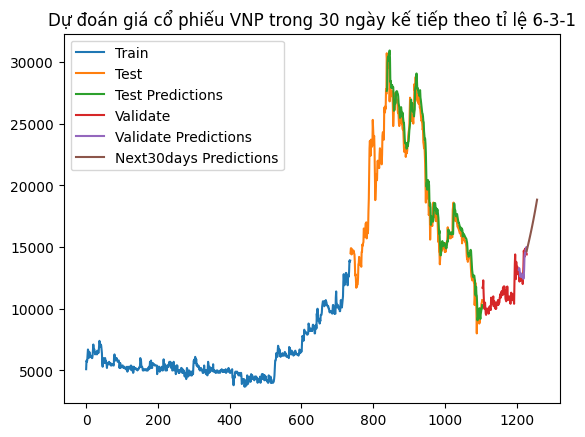

In [43]:
#Drawing plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(VNP1)-1, stop=len(VNP1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Test Predictions','Validate','Validate Predictions','Next30days Predictions'])
plt.title("Dự đoán giá cổ phiếu VNP trong 30 ngày kế tiếp theo tỉ lệ 6-3-1")
plt.show()

# 6. Chia tập dữ liệu để train-test-validate theo tỉ lệ 5:3:2

In [44]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(VNP1))
test_size = int(0.3 * len(VNP1))
val_size = len(VNP1) - train_size - test_size

In [45]:
train_data = VNP1[:train_size]
test_data = VNP1[train_size:train_size+test_size]
val_data = VNP1[train_size+test_size:]

<h1>Hàm Create Dataset

In [46]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [47]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [48]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [49]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [50]:
#Model fitting
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 4s 182ms/step - loss: 0.0016 - val_loss: 0.2411
Epoch 2/100
9/9 [==============================] - 1s 109ms/step - loss: 7.5393e-04 - val_loss: 0.2505
Epoch 3/100
9/9 [==============================] - 1s 107ms/step - loss: 5.5160e-04 - val_loss: 0.1634
Epoch 4/100
9/9 [==============================] - 1s 87ms/step - loss: 3.9314e-04 - val_loss: 0.1250
Epoch 5/100
9/9 [==============================] - 1s 71ms/step - loss: 2.9351e-04 - val_loss: 0.0694
Epoch 6/100
9/9 [==============================] - 1s 64ms/step - loss: 2.1071e-04 - val_loss: 0.0380
Epoch 7/100
9/9 [==============================] - 1s 66ms/step - loss: 1.4770e-04 - val_loss: 0.0142
Epoch 8/100
9/9 [==============================] - 1s 76ms/step - loss: 1.1334e-04 - val_loss: 0.0032
Epoch 9/100
9/9 [==============================] - 1s 64ms/step - loss: 1.0220e-04 - val_loss: 0.0021
Epoch 10/100
9/9 [==============================] - 1s 65ms/step - loss: 1.0127e-04

<h1>Dự báo dữ liệu test, val

In [51]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 11ms/step


<h1>Chuẩn hóa dữ liệu

In [52]:
#Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [53]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[10400.],
       [10700.],
       [11000.],
       [12200.],
       [12800.],
       [12300.],
       [11900.],
       [12000.],
       [12200.],
       [12200.],
       [12900.],
       [12900.],
       [12800.],
       [12500.],
       [12400.],
       [11900.],
       [12500.],
       [12700.],
       [12600.],
       [13000.],
       [13900.],
       [13800.],
       [13900.],
       [14500.],
       [14900.],
       [14900.],
       [14400.],
       [14700.],
       [14800.],
       [14600.],
       [14500.],
       [14600.],
       [14700.],
       [14500.],
       [14400.],
       [13800.],
       [12700.],
       [12800.],
       [12400.],
       [11700.],
       [11900.],
       [11800.],
       [12000.],
       [12000.],
       [12500.],
       [13600.],
       [13700.],
       [14200.],
       [13700.],
       [13800.],
       [13800.],
       [13500.],
       [13600.],
       [13400.],
       [14600.],
       [14600.],
       [15200.],
       [15100.],
       [15300.

In [54]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[12000.],
       [10300.],
       [10800.],
       [12100.],
       [10600.],
       [10800.],
       [ 9700.],
       [ 8000.],
       [ 9300.],
       [ 9200.],
       [ 9500.],
       [ 9800.],
       [10000.],
       [10000.],
       [ 8800.],
       [ 8900.],
       [ 9700.],
       [ 9800.],
       [10000.],
       [ 9900.],
       [10400.],
       [10500.],
       [10700.],
       [11700.],
       [11700.],
       [12300.],
       [11300.],
       [10500.],
       [10000.],
       [10000.],
       [10500.],
       [10000.],
       [ 9600.],
       [ 9500.],
       [10000.],
       [10000.],
       [10000.],
       [10000.],
       [10000.],
       [10000.],
       [ 9600.],
       [10000.],
       [10100.],
       [10200.],
       [ 9900.],
       [10000.],
       [ 9900.],
       [10900.],
       [10600.],
       [10400.],
       [10500.],
       [10700.],
       [10800.],
       [11000.],
       [10200.],
       [10400.],
       [10600.],
       [10300.],
       [10200.

<h1>Đánh giá độ chính xác của thuật toán

In [55]:
# RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 595.5328384576912
Testing RMSE: 895.3547035464799


In [56]:
#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 420.9076479559078
Testing MAE: 633.2847722085675


In [57]:
#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 3.7588886432507627
Testing MAPE: 3.107351856415592


<h1>Quá trình dự đoán giá cổ phiếu trong 30 ngày tiếp theo

In [71]:
x_input=val_data[147:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.39154318]
101
1 day input [0.25555556 0.24814815 0.25185185 0.25925926 0.26296296 0.27037037
 0.24074074 0.24814815 0.25555556 0.24444444 0.24074074 0.23333333
 0.24074074 0.23333333 0.25185185 0.24814815 0.25185185 0.24444444
 0.25925926 0.24444444 0.24814815 0.25185185 0.25185185 0.26666667
 0.27037037 0.27777778 0.26666667 0.27407407 0.28518519 0.27777778
 0.28518519 0.27407407 0.2962963  0.28518519 0.3        0.28888889
 0.3        0.27777778 0.28888889 0.26296296 0.25925926 0.25555556
 0.25925926 0.27777778 0.3        0.27777778 0.25925926 0.26296296
 0.26296296 0.26666667 0.27037037 0.26666667 0.25185185 0.24814815
 0.25925926 0.28148148 0.26666667 0.26296296 0.27777778 0.25925926
 0.25925926 0.25925926 0.25925926 0.24814815 0.31111111 0.36666667
 0.3962963  0.34444444 0.32222222 0.37407407 0.35185185 0.33703704
 0.35925926 0.33703704 0.34444444 0.35185185 0.34444444 0.32962963
 0.31481481 0.34074074 0.32592593 0.31851852 0.32222222 0.32962963
 0.32592593 0.31851852 0.33703704

In [72]:
print(scaler.inverse_transform(lst_output))

[[14271.66585326]
 [14147.85964489]
 [14024.56198335]
 [13902.11082697]
 [13780.64216375]
 [13660.21956205]
 [13540.88486433]
 [13422.64933586]
 [13305.52021861]
 [13189.48705196]
 [13074.54500794]
 [12960.68603992]
 [12847.89244533]
 [12736.16020083]
 [12625.47079921]
 [12515.81699848]
 [12407.18753338]
 [12299.57113862]
 [12192.95735359]
 [12087.33249903]
 [11982.68933296]
 [11879.01659012]
 [11776.30541921]
 [11674.54696894]
 [11573.73077869]
 [11473.84638786]
 [11374.88735914]
 [11276.84323192]
 [11179.70354557]
 [11083.46588612]]


<h1>Vẽ hình mô tả dự đoán

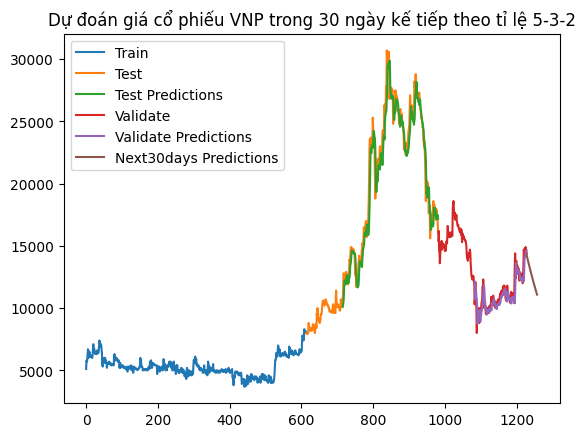

In [73]:
#Drawing plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(VNP1)-1, stop=len(VNP1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Test Predictions','Validate','Validate Predictions','Next30days Predictions'])
plt.title("Dự đoán giá cổ phiếu VNP trong 30 ngày kế tiếp theo tỉ lệ 5-3-2")
plt.show()